In [30]:
import numpy as np
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as clrs
import matplotlib.cm as cm
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import re
import collections
import string
from collections import OrderedDict
import random
from collections import Counter
import statistics
num_regex = re.compile(r'\d+')
import os
import operator
import pandas as pd
import string

plt.rcParams["font.family"] = "Times New Roman"

## This notebook is used to plot the genotype distributions for some given runs (the pink and blue plots)

In [31]:
nRuns = 100
runID_offsets = [0, 100]
duration = 4368 #duration of sims in hours - equivalent to 26 weeks
dates = ["24-Sep-2020", "09-Oct-2020", "14-Oct-2020", "06-Nov-2020", "16-Nov-2020", "25-Nov-2020"] #dates the simulations were performed on
pc_res = [14, 15, 16] #percentages of the populations which are resistant to the applied biocide
phase2_str = "phase2"

#parameters for the log normal distributions used
#[scale, sigma]
log_norm_params_14pcRes = [2.703747953786337, 0.5690825284230452]
log_norm_params_15pcRes = [2.6133256846855746, 0.6260058161550592]
log_norm_params_16pcRes = [2.47772924764521, 0.7060073500033884]

In [32]:
def getFilepathToGenoRuns(date, pc_res, phase):
    '''
    creates a string with the file location of the genotype distributions (all the run_ID files)
    '''
    
    return "geno_distb_data_"+phase+"/"+str(pc_res)+"_resistant-"+date


def getEventCountersDataframe(date, pc_res, phase, sigma, duration):
    
    return pd.read_csv("geno_distb_data_"+phase+"/"+str(pc_res)+"_resistant-"+date+"/"+str(pc_res)+"_resistant-"+date+"-event_counters-sigma="+"{:.5f}".format(sigma)+"-t="+str(duration)+".0.csv")


def getListOfMeasurementTimes(directory_name):
    '''
    for each runID directory, this gets the filenames and extracts a list of the times they were sampled at.
    directory_name is of form path_to_files/runID_<n>
    
    returns: sorted list of the time vals, in string form with 2 decimal places
    '''
    time_list = []
    def get_numbers_from_filename(filename):
        return re.search(r'(\d+(?:\.\d+)?)', filename).group(0)
    
    for filename in os.listdir(directory_name):
        time_list.append(float(get_numbers_from_filename(filename)))

    return ["{:.2f}".format(float(t)) for t in sorted(time_list)]

In [33]:
#due to different sessions having different numbers of runs, we'll use the 
event_counters_14pc_24Sep = getEventCountersDataframe(dates[0], pc_res[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_14pc_24Sep["date"] = "24-Sep-2020"
event_counters_15pc_24Sep = getEventCountersDataframe(dates[0], pc_res[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_15pc_24Sep["date"] = "24-Sep-2020"
event_counters_16pc_24Sep = getEventCountersDataframe(dates[0], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)
event_counters_16pc_24Sep["date"] = "24-Sep-2020"

event_counters_14pc_09Oct = getEventCountersDataframe(dates[1], pc_res[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_14pc_09Oct["date"] = "09-Oct-2020"
event_counters_15pc_09Oct = getEventCountersDataframe(dates[1], pc_res[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_15pc_09Oct["date"] = "09-Oct-2020"
event_counters_16pc_09Oct = getEventCountersDataframe(dates[1], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)
event_counters_16pc_09Oct["date"] = "09-Oct-2020"

event_counters_14pc_14Oct = getEventCountersDataframe(dates[2], pc_res[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_14pc_14Oct["date"] = "14-Oct-2020"
event_counters_15pc_14Oct = getEventCountersDataframe(dates[2], pc_res[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_15pc_14Oct["date"] = "14-Oct-2020"
event_counters_16pc_14Oct = getEventCountersDataframe(dates[2], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)
event_counters_16pc_14Oct["date"] = "14-Oct-2020"

event_counters_14pc_06Nov = getEventCountersDataframe(dates[3], pc_res[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_14pc_06Nov["date"] = "06-Nov-2020"
event_counters_15pc_06Nov = getEventCountersDataframe(dates[3], pc_res[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_15pc_06Nov["date"] = "06-Nov-2020"
event_counters_16pc_06Nov = getEventCountersDataframe(dates[3], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)
event_counters_16pc_06Nov["date"] = "06-Nov-2020"

event_counters_14pc_16Nov = getEventCountersDataframe(dates[4], pc_res[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_14pc_16Nov["date"] = "16-Nov-2020"
event_counters_15pc_16Nov = getEventCountersDataframe(dates[4], pc_res[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_15pc_16Nov["date"] = "16-Nov-2020"
event_counters_16pc_16Nov = getEventCountersDataframe(dates[4], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)
event_counters_16pc_16Nov["date"] = "16-Nov-2020"

event_counters_14pc_25Nov = getEventCountersDataframe(dates[5], pc_res[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_14pc_25Nov["date"] = "25-Nov-2020"
event_counters_15pc_25Nov = getEventCountersDataframe(dates[5], pc_res[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_15pc_25Nov["date"] = "25-Nov-2020"
event_counters_16pc_25Nov = getEventCountersDataframe(dates[5], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)
event_counters_16pc_25Nov["date"] = "25-Nov-2020"


In [34]:
all_event_counters_14pc = pd.concat([event_counters_14pc_24Sep, event_counters_14pc_09Oct, event_counters_14pc_14Oct, event_counters_14pc_06Nov, 
                                     event_counters_14pc_16Nov, event_counters_14pc_25Nov], ignore_index=True)

all_event_counters_15pc = pd.concat([event_counters_15pc_24Sep, event_counters_15pc_09Oct, event_counters_15pc_14Oct, event_counters_15pc_06Nov,
                                     event_counters_15pc_16Nov, event_counters_15pc_25Nov], ignore_index=True)

all_event_counters_16pc = pd.concat([event_counters_16pc_24Sep, event_counters_16pc_09Oct, event_counters_16pc_14Oct, event_counters_16pc_06Nov,
                                     event_counters_16pc_16Nov, event_counters_16pc_25Nov], ignore_index=True)
#all_event_counters_14pc[all_event_counters_14pc["bf_thickness"] > 0]
#print((all_event_counters_14pc[all_event_counters_14pc["runID"]==198]["date"].values[0]))
all_event_counters_14pc[all_event_counters_14pc["bf_thickness"] > 0].sort_values(by=["n_replications"], ascending=False)

,runID,bf_thickness,exit_time,final_pop,avg_pop,n_deaths,n_detachments,n_immigrations,n_migrations,n_replications,date
451,451,40,4347,16348,2107,206955,25857,86971,0,162184,16-Nov-2020
311,311,40,3961,16249,2256,200693,23970,79017,0,161890,06-Nov-2020
402,402,40,4285,16027,2104,198626,25954,85766,0,154836,16-Nov-2020
626,626,40,2406,16065,3548,171971,14290,48202,0,154119,25-Nov-2020
315,315,40,2367,16240,3545,170489,14154,47097,0,153781,06-Nov-2020
326,326,39,4368,16162,2047,197372,26075,86774,0,152830,06-Nov-2020
66,66,40,3735,16501,2277,188461,22315,74735,0,152537,24-Sep-2020
184,184,40,2304,16426,3447,167184,13664,46365,0,150904,09-Oct-2020
706,706,40,4174,16497,2024,192915,25129,83844,0,150692,25-Nov-2020
527,527,40,4339,16319,1987,194692,25995,86333,0,150668,25-Nov-2020


In [35]:
def getGenoDistbDict(runID, pc_res, phase_val, event_counters):
    '''
    gets a dict containing the geno distbs over time.
    each key is the time step.
    each entry is a dataframe containing the genotypes in each microhabitat
    '''
    
    runID_key = "runID_"+str(runID)
    #due to the varying no. of runs in each session, (depending on % resistant) we'll use the counters dataframe to get the date
    date = event_counters[event_counters["runID"]==runID]["date"].values[0]

    
    directoryPath = getFilepathToGenoRuns(date=date, pc_res=pc_res, phase=phase_val)
    filepath_runID = directoryPath+"/"+runID_key
    
    geno_time_dict = {} #dictionary containing geno dataframes for each timestep
    time_list = getListOfMeasurementTimes(filepath_runID) #sorted list of the times that the genos were sampled at in this run
    
    for t in time_list:
            
        filepath_time = filepath_runID+"/geno_distb-t="+t+".csv"

        #need to swap the rows and columns so that the microhabitat is the key in the dataframe
        #geno_df = pd.read_csv(filename, header=None).T
        geno_df = pd.DataFrame([line.strip().split(',') for line in open(filepath_time, 'r')]).T
        #geno
        new_header = geno_df.iloc[0] #grab the first row for the header
        geno_df = geno_df[1:] #take the data less the header row
        geno_df.columns = new_header #set the header row as the df header

        geno_df = geno_df.astype(float)

        #round the time to the nearest integer value to make reading it in easier
        #the [-3] is so the decimal point and decimal numbers are removed when casting the string to an int
        geno_time_dict[int(t[:-3])] = geno_df
    
    return geno_time_dict
    
    

In [36]:
def plotGenoDistbsInSystemOverTime_WRT_N(geno_dict, runID, pc_res, event_counters):
    '''
    This is the method that makes the big blue and pink plots, showing the distribution of genotypes over time throughout the system
    Input is the geno_dict, where each key is the timestep and each entry is a dataframe where each column is the genotypes in each microhabitat
    
    This plots the size of the pop distb and the various genotypes as a function of N. (height of bars not normalised currently)
    
    NB: it might be better to normalise the geno plots for the vs N ones, but not normalise the ones vs t
    '''
    
    #make a new dict where each key is the timestep, each entry is the dataframe values condensed into a single array (2D dataframe -> 1D array)
    collated_geno_dict = {}
    n_dict = {} #this will save the pop size N at time t (bit overengineered, this is kinda shoehorned in to plot vs N instead of t)
    min_geno_val = 9e9
    max_geno_val = 0. #this will be updated to be the genotype of the most resistant bacteria in the system, used for scaling the colourmap
    
    for t in geno_dict.keys():
        #gets all the genotypes from the dataframe, removes NaNs and converts to 1D numpy array
        #round the genotypes to n decimal places
        processed_genos = np.around(geno_dict[t].values[~np.isnan(geno_dict[t].values)].flatten(), decimals=0)
        max_geno_val = max(np.max(processed_genos), max_geno_val)
        min_geno_val = min(np.min(processed_genos), min_geno_val)
        #dict containing the species genotypes (keys) and no. of ocurrences of each (values)
        geno_counts = Counter(processed_genos)
        n_bac = sum(geno_counts.values())
#         print(n_bac)
#         print(geno_counts.keys())
#         print(geno_counts.values())
        #sort the geno counts so they're arranged in order of increasing resistance
        geno_counts = dict(sorted(geno_counts.items()))
        
        '''this for loop is the bit where the height normalisation happens'''
        for key in geno_counts:
            geno_counts[key] = geno_counts[key]/n_bac
        #divide the counts by the total no. of bacteria
#         normalised_geno_counts = {k: v/n_bac for k, v in geno_counts}
        
#         print()
#         print(geno_counts.keys())
#         print(geno_counts.values())
#         #print(max_geno_val)
        collated_geno_dict[t] = geno_counts
        n_dict[t] = n_bac
        
    
    
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 6.2)
    titleSize = 16
    labelSize = 16
    numbersize = 12
    legendsize = 10
    IDsize=12

    colour_list = []
    t_last = 0
    n_old = 0 #used for getting the width of the bars
    for t in collated_geno_dict.keys():
        bar_ypos = 0 #used to adjust the bottom of the bar chart so we can stack bacteria on top of one another
        for geno_val in collated_geno_dict[t].keys():
            #print(geno_val)
            percent_of_max_r = geno_val/max_geno_val #how resistant is this genotype compared to the most resistant one
            geno_colour = (percent_of_max_r, 0.3*percent_of_max_r, 0.42) #colour representing the genotype's resistance
            #colour_list.append(geno_colour)
            geno_colour2 = cm.magma(percent_of_max_r)
            
            bars = ax.bar(x = n_dict[t], height=collated_geno_dict[t][geno_val], bottom=bar_ypos, color=geno_colour2, width=(n_dict[t] - n_old)+160, label=geno_val)
            bar_ypos += collated_geno_dict[t][geno_val]
        
        n_old = n_dict[t]
        t_last = float(t)
        n_last = float(n_dict[t])
    #cmap = clrs.LinearSegmentedColormap.from_list("", colour_list)
#     handles, labels = ax.get_legend_handles_labels()
#     unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
#     ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(1.02,0.8), fontsize='large', ncol=3)
#     plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1.02,0.8), fontsize='large', ncol=3)
    
        #we've now got all the genos over time, sorted and normalised, and know the max val.
    #now we need to translate this into a bar chart

    
    cmap_string = "magma"
    sm = plt.cm.ScalarMappable(cmap=cmap_string)
    sm.set_array([])
    n_ticks = 6

    cbar = fig.colorbar(sm)
    cbar.ax.locator_params(nbins=n_ticks)
    ctick_labels = ["{:.1f}".format(x) for x in list(np.linspace(min_geno_val, max_geno_val, n_ticks))]
    cbar.ax.set_yticklabels(ctick_labels) 
    cbar.ax.tick_params(labelsize=labelSize)
    cbar.set_label("resistance", fontsize=labelSize)
    
    ax.set_ylabel('$n_i/N$', fontsize=labelSize)
    ax.set_xlabel('N', fontsize=labelSize)
    plt.xticks(fontsize=18)
    plt.locator_params(axis='x', nbins=4)
    plt.yticks(fontsize=18)
    
    #print(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values)
    plt.title(str(pc_res)+'% resistant,    '+'run: '+str(runID)+'    thickness: '+str(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values[0])+"$\mu m$", fontsize=titleSize)
    plt.xlim(0, n_last)
    plt.ylim(0, 1)
    
    plt.savefig('geno_distb_plots/'+str(pc_res)+"pc_res-runID_"+str(runID)+"vs_N.png")
    plt.show()
    
    
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 6.2)
    titleSize = 16
    labelSize = 16
    numbersize = 12
    legendsize = 10
    IDsize=12
    
    #print(list(n_dict.keys()))
    ax.plot(list(n_dict.keys()), list(n_dict.values()))
    ax.set_ylabel('$N$', fontsize=labelSize)
    ax.set_xlabel('t', fontsize=labelSize)
    plt.xticks(fontsize=18)
    plt.locator_params(axis='x', nbins=4)
    plt.yticks(fontsize=18)
    
    #print(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values)
    plt.title(str(pc_res)+'% resistant,    '+'run: '+str(runID)+'    thickness: '+str(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values[0])+"$\mu m$", fontsize=titleSize)
    
    
    plt.show()

In [37]:
def plotGenoDistbsInSystemOverTime_WRT_t(geno_dict, runID, pc_res, event_counters):
    '''
    This is the method that makes the big blue and pink plots, showing the distribution of genotypes over time throughout the system
    Input is the geno_dict, where each key is the timestep and each entry is a dataframe where each column is the genotypes in each microhabitat
    
    This plots the size of the pop distb and the various genotypes as a function of N. (height of bars not normalised currently)
    
    NB: it might be better to normalise the geno plots for the vs N ones, but not normalise the ones vs t
    '''
    
    #make a new dict where each key is the timestep, each entry is the dataframe values condensed into a single array (2D dataframe -> 1D array)
    collated_geno_dict = {}
    n_dict = {} #this will save the pop size N at time t (bit overengineered, this is kinda shoehorned in to plot vs N instead of t)
    min_geno_val = 9e9
    max_geno_val = 0. #this will be updated to be the genotype of the most resistant bacteria in the system, used for scaling the colourmap
    
    for t in geno_dict.keys():
        #gets all the genotypes from the dataframe, removes NaNs and converts to 1D numpy array
        #round the genotypes to n decimal places
        processed_genos = np.around(geno_dict[t].values[~np.isnan(geno_dict[t].values)].flatten(), decimals=0)
        max_geno_val = max(np.max(processed_genos), max_geno_val)
        min_geno_val = min(np.min(processed_genos), min_geno_val)
        #dict containing the species genotypes (keys) and no. of ocurrences of each (values)
        geno_counts = Counter(processed_genos)
        n_bac = sum(geno_counts.values())
#         print(n_bac)
#         print(geno_counts.keys())
#         print(geno_counts.values())
        #sort the geno counts so they're arranged in order of increasing resistance
        geno_counts = dict(sorted(geno_counts.items()))
        
        '''this for loop is the bit where the height normalisation happens'''
#         for key in geno_counts:
#             geno_counts[key] = geno_counts[key]/n_bac
        #divide the counts by the total no. of bacteria
#         normalised_geno_counts = {k: v/n_bac for k, v in geno_counts}
        
#         print()
#         print(geno_counts.keys())
#         print(geno_counts.values())
#         #print(max_geno_val)
        collated_geno_dict[t] = geno_counts
        n_dict[t] = n_bac
        
    
    
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 6.2)
    titleSize = 16
    labelSize = 16
    numbersize = 12
    legendsize = 10
    IDsize=12

    colour_list = []
    t_last = 0
    t_list = list(collated_geno_dict.keys())
    delta_t = (t_list[1] - t_list[0]) + 1.
    for t in collated_geno_dict.keys():
        bar_ypos = 0 #used to adjust the bottom of the bar chart so we can stack bacteria on top of one another
        #print(t)
        for geno_val in collated_geno_dict[t].keys():
            #print(geno_val)
            percent_of_max_r = geno_val/max_geno_val #how resistant is this genotype compared to the most resistant one
            #geno_colour = (percent_of_max_r, 0.3*percent_of_max_r, 0.42) #colour representing the genotype's resistance
            #colour_list.append(geno_colour)
            geno_colour2 = cm.magma(percent_of_max_r)
            
            bars = ax.bar(x = t, height=collated_geno_dict[t][geno_val], bottom=bar_ypos, color=geno_colour2, width=delta_t, label=geno_val)
            bar_ypos += collated_geno_dict[t][geno_val]
        
        t_last = float(t)
        n_last = float(n_dict[t])
    #cmap = clrs.LinearSegmentedColormap.from_list("", colour_list)
#     handles, labels = ax.get_legend_handles_labels()
#     unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
#     ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(1.02,0.8), fontsize='large', ncol=3)
#     plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1.02,0.8), fontsize='large', ncol=3)
    
        #we've now got all the genos over time, sorted and normalised, and know the max val.
    #now we need to translate this into a bar chart

    
    cmap_string = "magma"
    sm = plt.cm.ScalarMappable(cmap=cmap_string)
    sm.set_array([])
    n_ticks = 6

    cbar = fig.colorbar(sm)
    cbar.ax.locator_params(nbins=n_ticks)
    ctick_labels = ["{:.1f}".format(x) for x in list(np.linspace(min_geno_val, max_geno_val, n_ticks))]
    cbar.ax.set_yticklabels(ctick_labels) 
    cbar.ax.tick_params(labelsize=labelSize)
    cbar.set_label("resistance", fontsize=labelSize)
    
    ax.set_ylabel('$n_i/N$', fontsize=labelSize)
    ax.set_xlabel('t', fontsize=labelSize)
    plt.xticks(fontsize=18)
    plt.locator_params(axis='x', nbins=4)
    plt.yticks(fontsize=18)
    
    #print(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values)
    plt.title(str(pc_res)+'% resistant,    '+'run: '+str(runID)+'    thickness: '+str(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values[0])+"$\mu m$", fontsize=titleSize)
    plt.xlim(0, t_last)
    #plt.ylim(0, 1)
    
    plt.savefig('geno_distb_plots/'+str(pc_res)+"pc_res-runID_"+str(runID)+"_vs_t.png")
    plt.show()
    
    
#     fig, ax = plt.subplots()
#     fig.set_size_inches(9, 6.2)
#     titleSize = 16
#     labelSize = 16
#     numbersize = 12
#     legendsize = 10
#     IDsize=12
    
#     #print(list(n_dict.keys()))
#     ax.plot(list(n_dict.keys()), list(n_dict.values()))
#     ax.set_ylabel('$N$', fontsize=labelSize)
#     ax.set_xlabel('t', fontsize=labelSize)
#     plt.xticks(fontsize=18)
#     plt.locator_params(axis='x', nbins=4)
#     plt.yticks(fontsize=18)
    
#     #print(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values)
#     plt.title(str(pc_res)+'% resistant,    '+'run: '+str(runID)+'    thickness: '+str(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values[0])+"$\mu m$", fontsize=titleSize)
    
    
    #plt.show()

In [38]:
# x = getGenoDistbDict(184, 14, phase2_str, all_event_counters_14pc)
# plotGenoDistbsInSystemOverTime_WRT_N(x, runID=184, pc_res=14, event_counters=all_event_counters_14pc)
# plotGenoDistbsInSystemOverTime_WRT_t(x, runID=184, pc_res=14, event_counters=all_event_counters_14pc)


In [39]:
# run_id = 49
# pc_resistant = 14
# x = getGenoDistbDict(runID=run_id, pc_res=pc_resistant, phase_val=phase2_str, event_counters=all_event_counters_14pc)
# plotGenoDistbsInSystemOverTime_WRT_N(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_14pc)
# plotGenoDistbsInSystemOverTime_WRT_t(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_14pc)

In [40]:
# run_id = 193
# pc_resistant = 14
# x = getGenoDistbDict(runID=run_id, pc_res=pc_resistant, phase_val=phase2_str, event_counters=all_event_counters_14pc)
# plotGenoDistbsInSystemOverTime_WRT_N(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_14pc)
# plotGenoDistbsInSystemOverTime_WRT_t(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_14pc)


In [41]:
# run_id = 94
# pc_resistant = 15
# x = getGenoDistbDict(runID=run_id, pc_res=pc_resistant, phase_val=phase2_str, event_counters=all_event_counters_15pc)
# plotGenoDistbsInSystemOverTime_WRT_N(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_15pc)
# plotGenoDistbsInSystemOverTime_WRT_t(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_15pc)

In [42]:
# run_id = 172
# pc_resistant = 15
# x = getGenoDistbDict(runID=run_id, pc_res=pc_resistant, phase_val=phase2_str, event_counters=all_event_counters_15pc)
# plotGenoDistbsInSystemOverTime_WRT_N(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_15pc)
# plotGenoDistbsInSystemOverTime_WRT_t(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_15pc)

In [43]:
# run_id = 15
# pc_resistant = 16
# x = getGenoDistbDict(runID=run_id, pc_res=pc_resistant, phase_val=phase2_str, event_counters=all_event_counters_16pc)
# plotGenoDistbsInSystemOverTime_WRT_N(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_16pc)
# plotGenoDistbsInSystemOverTime_WRT_t(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_16pc)

In [44]:
# run_id = 91
# pc_resistant = 16
# x = getGenoDistbDict(runID=run_id, pc_res=pc_resistant, phase_val=phase2_str, event_counters=all_event_counters_16pc)
# plotGenoDistbsInSystemOverTime_WRT_N(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_16pc)
# plotGenoDistbsInSystemOverTime_WRT_t(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_16pc)

In [45]:
def getN_maxAndGeno_max(geno_data_list):
    '''
    Takes in a list of geno data dicts and returns the values of the most resistant bug and the largest pop size in them.
    This is used for calibrating the y-axis and colour bar for when we have several geno plots.
    '''
    
    n_max = 0.
    geno_max = 0.
    
    for geno_dict in geno_data_list:
        for t in geno_dict.keys():
            #gets all the genotypes from the dataframe, removes NaNs and converts to 1D numpy array
            #round the genotypes to n decimal places
            processed_genos = np.around(geno_dict[t].values[~np.isnan(geno_dict[t].values)].flatten(), decimals=0)
            geno_max = max(np.max(processed_genos), geno_max)


            geno_counts = Counter(processed_genos)
            n_max = max(sum(geno_counts.values()), n_max)
        
    
    return n_max, geno_max

In [46]:
pcres_14_run_a = getGenoDistbDict(17, 14, phase2_str, all_event_counters_14pc)
pcres_14_run_b = getGenoDistbDict(541, 14, phase2_str, all_event_counters_14pc)
pcres_14_run_c = getGenoDistbDict(707, 14, phase2_str, all_event_counters_14pc)
pcres_14_run_d = getGenoDistbDict(351, 14, phase2_str, all_event_counters_14pc)
geno_2x2_plot_data = [pcres_14_run_a, pcres_14_run_b, pcres_14_run_c, pcres_14_run_d]
n_max_2x2, geno_max_2x2 = getN_maxAndGeno_max(geno_2x2_plot_data)


# these were for the 3x3 plots
pcres_14_run_A = getGenoDistbDict(707, 14, phase2_str, all_event_counters_14pc)
pcres_14_run_B = getGenoDistbDict(541, 14, phase2_str, all_event_counters_14pc)
pcres_14_run_C = getGenoDistbDict(451, 14, phase2_str, all_event_counters_14pc)
pcres_15_run_D = getGenoDistbDict(251, 15, phase2_str, all_event_counters_15pc)
pcres_15_run_E = getGenoDistbDict(172, 15, phase2_str, all_event_counters_15pc)
pcres_15_run_F = getGenoDistbDict(269, 15, phase2_str, all_event_counters_15pc)
pcres_16_run_G = getGenoDistbDict(25, 16, phase2_str, all_event_counters_16pc)
pcres_16_run_H = getGenoDistbDict(115,  16, phase2_str, all_event_counters_16pc)
pcres_16_run_I = getGenoDistbDict(209,  16, phase2_str, all_event_counters_16pc)
geno_3x3_plot_data = [pcres_14_run_A, pcres_14_run_B, pcres_14_run_C, pcres_15_run_D, pcres_15_run_E, pcres_15_run_F, pcres_16_run_G, pcres_16_run_H, pcres_16_run_I]
n_max, geno_max = getN_maxAndGeno_max(geno_3x3_plot_data)

In [47]:
def plot2x2GridOfGenoDistbs_wrt_t(geno_data_list, N_max, geno_max):
    '''
    Plots a 2x2 grid of of the geno distbs to compare the different ways in which they can grow.
    4 randomly selected biofilms which exhibited growth, 
    This one plots the population vs time, height is not normalised
    '''
    
    fig, axes = plt.subplots(2, 2, dpi=120, sharey=True, sharex=True)
    plt.subplots_adjust(wspace=0.08, hspace=0.12)
    fig.set_size_inches(8,6)
    titleSize = 16
    labelSize = 16
    numbersize = 12
    legendsize = 10
    IDsize=12
    
    letters = list(string.ascii_lowercase)[:len(geno_data_list)]
    
    for ax, geno_data, letter in zip(axes.flat, geno_data_list, letters):
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        #make a new dict where each key is the timestep, each entry is the dataframe values condensed into a single array (2D dataframe -> 1D array)
        collated_geno_dict = {}
        n_dict = {} #this will save the pop size N at time t (bit overengineered, this is kinda shoehorned in to plot vs N instead of t)

        for t in geno_data.keys():
            #gets all the genotypes from the dataframe, removes NaNs and converts to 1D numpy array
            #round the genotypes to n decimal places
            processed_genos = np.around(geno_data[t].values[~np.isnan(geno_data[t].values)].flatten(), decimals=0)

            #dict containing the species genotypes (keys) and no. of ocurrences of each (values)
            geno_counts = Counter(processed_genos)
            n_bac = sum(geno_counts.values())
            #sort the geno counts so they're arranged in order of increasing resistance
#             geno_counts = dict(sorted(geno_counts.items()))
            geno_counts = dict((geno_counts.items()))

            collated_geno_dict[t] = geno_counts
            n_dict[t] = n_bac


        colour_list = []
        t_last = 0
        t_list = list(collated_geno_dict.keys())
        delta_t = (t_list[1] - t_list[0]) + 1.
        for t in collated_geno_dict.keys():
            bar_ypos = 0 #used to adjust the bottom of the bar chart so we can stack bacteria on top of one another
            #print(t)
            for geno_val in collated_geno_dict[t].keys():
                #print(geno_val)
                percent_of_max_r = geno_val/geno_max #how resistant is this genotype compared to the most resistant one
                #geno_colour = (percent_of_max_r, 0.3*percent_of_max_r, 0.42) #colour representing the genotype's resistance
                #colour_list.append(geno_colour)
                geno_colour2 = cm.magma(percent_of_max_r)

                bars = ax.bar(x = t, height=collated_geno_dict[t][geno_val], bottom=bar_ypos, color=geno_colour2, width=delta_t, label=geno_val, edgecolor=geno_colour2, linewidth=1)
                bar_ypos += collated_geno_dict[t][geno_val]

            t_last = float(t)
            n_last = float(n_dict[t])
            
        
        #ax.set_ylim(0, N_max)
        cmap = plt.get_cmap('magma')
        ax.set_xlim(0, duration)
        ax.text(0.02, 0.9, "("+letter+")", transform=ax.transAxes, fontsize=20)
        ax.set_xlabel("t (hr)", fontsize=22)
        ax.set_ylabel("N ($\\times 10^4$)", fontsize=22)
        ax.tick_params(axis='both', labelsize=18)
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax.yaxis.get_offset_text().set_visible(False)
        ax.label_outer()


    plt.savefig('geno_distb_plots/2x2_plot_vs_t.pdf', bbox_inches="tight")
    plt.show()
        
    

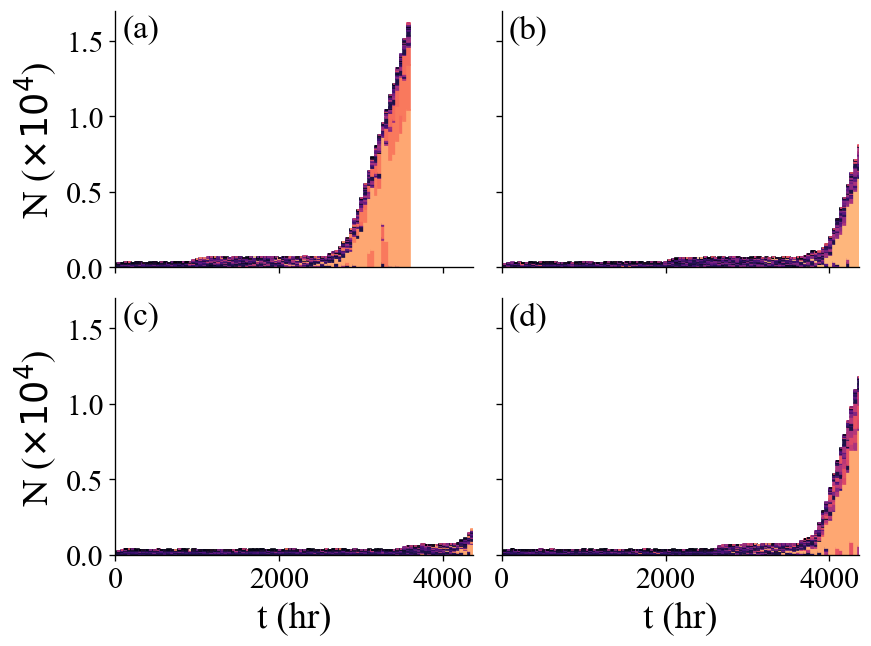

In [48]:
plot2x2GridOfGenoDistbs_wrt_t(geno_2x2_plot_data, N_max=n_max_2x2, geno_max=geno_max_2x2)

In [49]:
def plot2x2GridOfGenoDistbs_wrt_N(geno_data_list, N_max, geno_max):
    '''
    Plots a 3x3 grid of of the geno distbs to compare the different ways in which they can grow.
    Each row contains three runs from each of the 14-16% resistant runs.
    This one plots the population vs time, height is not normalised
    '''
    
    fig, axes = plt.subplots(2, 2, dpi=120, sharey=True, sharex=True)
    plt.subplots_adjust(wspace=0.08, hspace=0.16)
    fig.set_size_inches(8,6)
    titleSize = 16
    labelSize = 16
    numbersize = 12
    legendsize = 10
    IDsize=12
    
    letters = list(string.ascii_lowercase)[:len(geno_data_list)]
    
    for ax, geno_data, letter in zip(axes.flat, geno_data_list, letters):

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        #make a new dict where each key is the timestep, each entry is the dataframe values condensed into a single array (2D dataframe -> 1D array)
        collated_geno_dict = {}
        n_dict = {} #this will save the pop size N at time t (bit overengineered, this is kinda shoehorned in to plot vs N instead of t)
        min_geno_val = 9e9
        max_geno_val = 0. #this will be updated to be the genotype of the most resistant bacteria in the system, used for scaling the colourmap
        for t in geno_data.keys():
            #gets all the genotypes from the dataframe, removes NaNs and converts to 1D numpy array
            #round the genotypes to n decimal places
            processed_genos = np.around(geno_data[t].values[~np.isnan(geno_data[t].values)].flatten(), decimals=0)
#             max_geno_val = max(np.max(processed_genos), max_geno_val)
#             min_geno_val = min(np.min(processed_genos), min_geno_val)
            #dict containing the species genotypes (keys) and no. of ocurrences of each (values)
            geno_counts = Counter(processed_genos)
            n_bac = sum(geno_counts.values())
            #sort the geno counts so they're arranged in order of increasing resistance
            geno_counts = dict(sorted(geno_counts.items(), reverse=True))
#             geno_counts = dict((geno_counts.items()))

            '''this for loop is the bit where the height normalisation happens'''
            for key in geno_counts:
                geno_counts[key] = geno_counts[key]/n_bac
            #divide the counts by the total no. of bacteria
    #         normalised_geno_counts = {k: v/n_bac for k, v in geno_counts}

            collated_geno_dict[t] = geno_counts
            n_dict[t] = n_bac


        colour_list = []
        t_last = 0
        n_old = 0 #used for getting the width of the bars
        t_list = list(collated_geno_dict.keys())
        delta_t = (t_list[1] - t_list[0])+1.
        for t in collated_geno_dict.keys():
            bar_ypos = 0 #used to adjust the bottom of the bar chart so we can stack bacteria on top of one another
            for geno_val in collated_geno_dict[t].keys():
                #print(geno_val)
                percent_of_max_r = geno_val/geno_max #how resistant is this genotype compared to the most resistant one
                #geno_colour = (percent_of_max_r, 0.3*percent_of_max_r, 0.42) #colour representing the genotype's resistance
                #colour_list.append(geno_colour)
                geno_colour2 = cm.magma(percent_of_max_r)

#                 bars = ax.bar(x = n_dict[t], height=collated_geno_dict[t][geno_val], bottom=bar_ypos, color=geno_colour2, width=1.5*(n_dict[t] - n_old)+32, label=geno_val) # used for vs N plots
                # add the edgecolour to get rid of the pdf aliasing-type effects
                bars = ax.bar(x = t, height=collated_geno_dict[t][geno_val], bottom=bar_ypos, color=geno_colour2, width=delta_t, label=geno_val, edgecolor=geno_colour2, linewidth=1)
                bar_ypos += collated_geno_dict[t][geno_val]

            n_old = n_dict[t]
            t_last = float(t)
            n_last = float(n_dict[t])
            
        
        ax.set_ylim(0, 1.)
#         ax.set_xlim(0, N_max)
#         letter_colour = "black" if letters.index(letter)%3 < 2 else "white"
#         letter_x_coord = 0.83 if letters.index(letter)%3 < 2 else 0.04
#         ax.text(letter_x_coord, 0.895, "("+letter+")", transform=ax.transAxes, fontsize=16, color=letter_colour)
#         ax.set_xlabel("N", fontsize=22)
        ax.set_ylabel("n$_i$/N", fontsize=22)
        ax.set_xlabel("t (hr)", fontsize=22)
        ax.label_outer()
        #ax.axes.xaxis.set_ticklabels([]) # remove ticklabels
        
        #ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        ax.set_yticks([0., 0.5, 1.0])
        ax.set_xlim(0, duration)
        ax.text(0.01, 0.88, "("+letter+")", transform=ax.transAxes, fontsize=20, color='white')
        ax.tick_params(axis='both', labelsize=18)


    plt.savefig('geno_distb_plots/2x2_vs_t_scaled.pdf', bbox_inches="tight", dpi=330)
    plt.show()

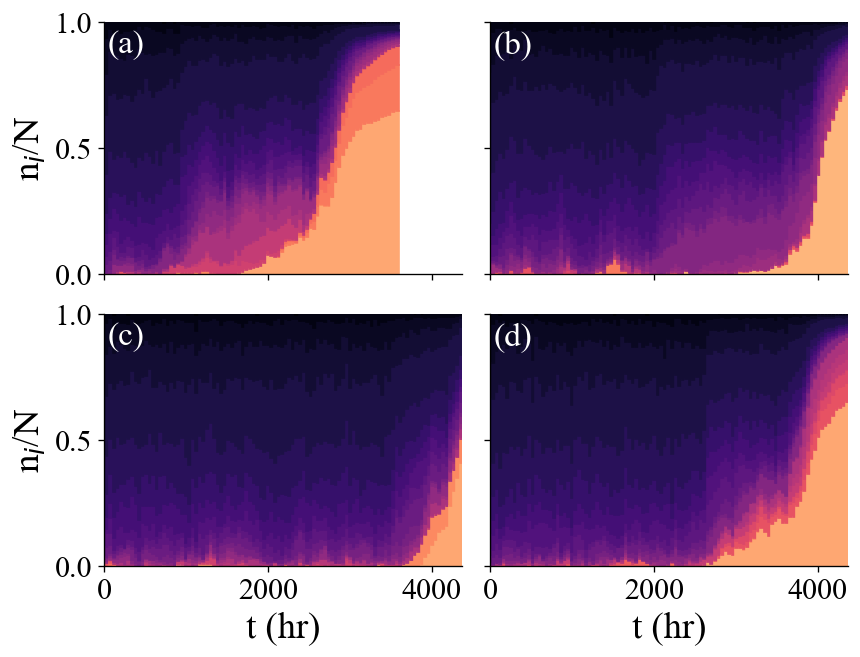

In [50]:
plot2x2GridOfGenoDistbs_wrt_N(geno_2x2_plot_data, N_max=n_max_2x2, geno_max=geno_max_2x2)

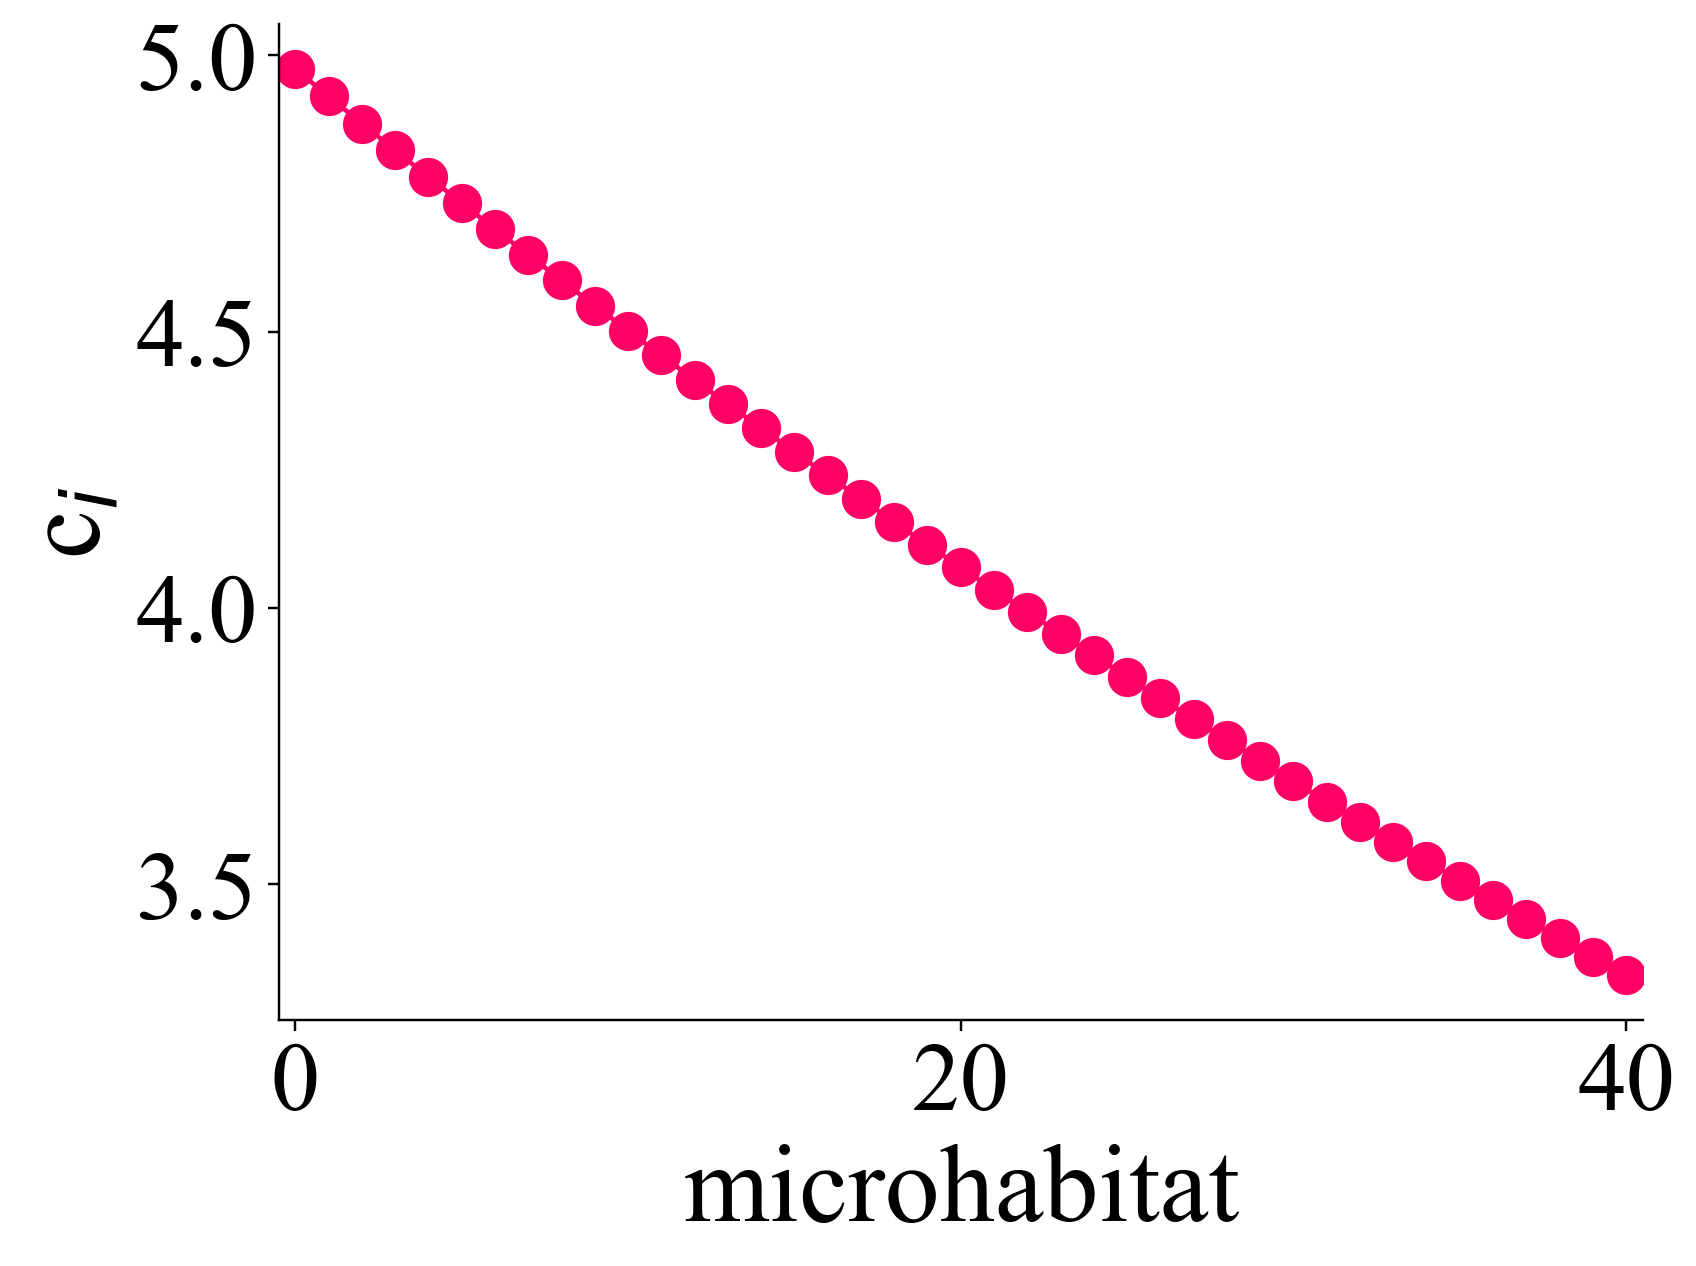

In [55]:
# plot the exponential gradient vs microhabitat for model diagram
fontsize=36
labelsize=32


fig, ax = plt.subplots(dpi=220)
fig.set_size_inches(8,6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
alpha = 0.01
c_max = 5

x = np.arange(0, 42, 1)
x_cont = np.linspace(0, 41, 1000)

def calc_exp(x, c_max, alpha):
    x_avg = (x[:-1] + x[1:])/2.
    #print(x_avg)
    return c_max*np.exp(-alpha*x_avg)

c_grad = calc_exp(x, c_max=c_max, alpha=alpha)
c_grad_cont = calc_exp(x_cont, c_max=c_max, alpha=alpha)

ax.scatter(x[:-1], c_grad, s=140, c='#ff0066')
ax.plot(x[:-1], c_grad, c='#ff0066')

ax.tick_params(axis='both', labelsize=labelsize)
ax.set_xlim(-0.5, 40.5)

ax.set_ylabel("c$_i$", fontsize=fontsize)
ax.set_xlabel("microhabitat", fontsize=fontsize)
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.savefig("geno_distb_plots/c_gradient.pdf", bbox_inches='tight')

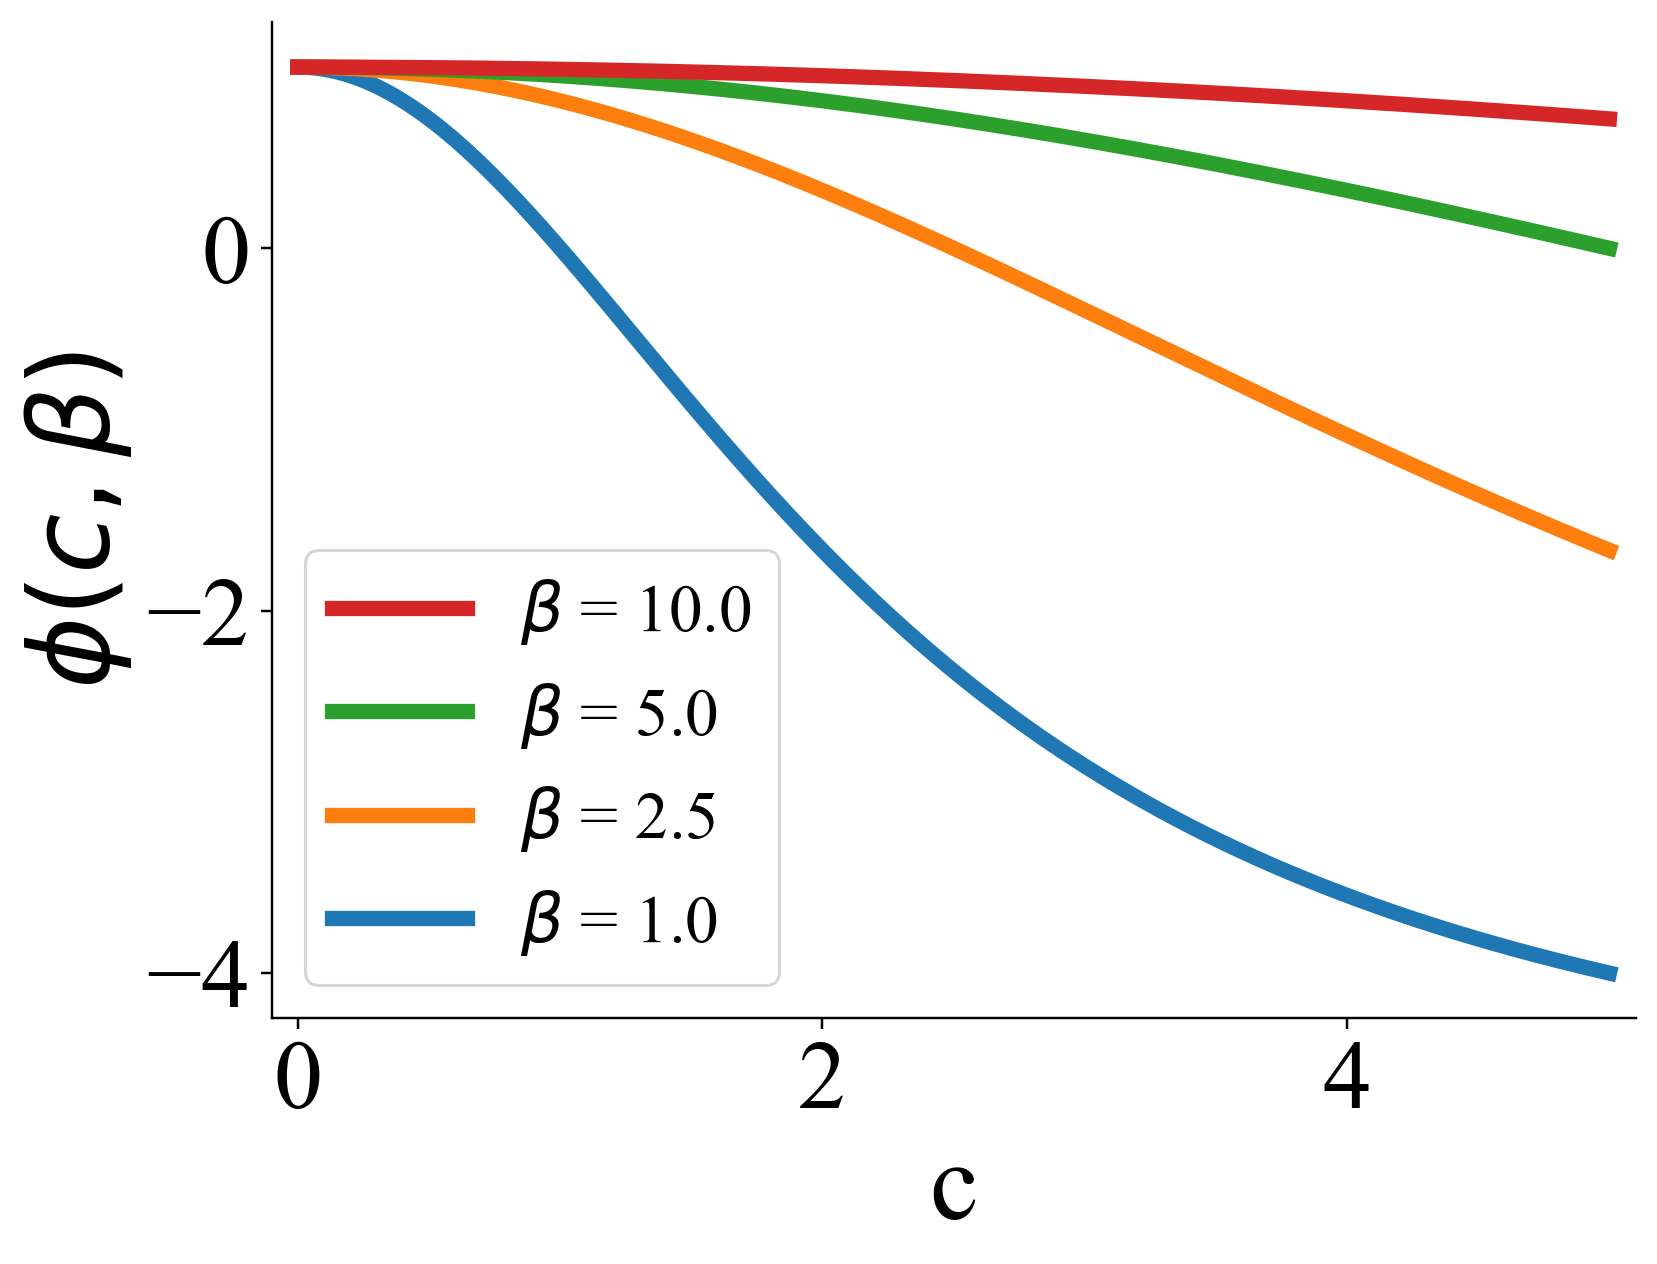

In [56]:
# plot some growth curves vs c for several beta values
fig, ax = plt.subplots(dpi=220)
fig.set_size_inches(8,6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


def growth_curve(c, beta):
    
    cB = c/beta
    
    return 1. - (6.*cB**2)/(5.+cB**2)

c = np.linspace(0, 5, 1000)

beta_vals = [1., 2.5, 5., 10.]

for b in beta_vals:
    ax.plot(c, growth_curve(c, b), label=f'$\\beta$ = {b:.1f}', lw=5)


ax.set_xlabel("c", fontsize=fontsize)
ax.set_ylabel("$\\phi(c,\\beta)$", fontsize=fontsize)
ax.tick_params(axis='both', labelsize=labelsize)
ax.set_xlim(-0.1, 5.1)
#ax.yaxis.set_major_locator(plt.MaxNLocator(4.2))

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=22)
#plt.legend()
plt.savefig("geno_distb_plots/growth_curves.pdf", bbox_inches='tight')
plt.show()

In [57]:
def plot3x3GridOfGenoDistbs_wrt_t(geno_data_list, N_max, geno_max):
    '''
    Plots a 3x3 grid of of the geno distbs to compare the different ways in which they can grow.
    Each row contains three runs from each of the 14-16% resistant runs.
    This one plots the population vs time, height is not normalised
    '''
    
    fig, axes = plt.subplots(3, 3, dpi=120, sharey=True, sharex=True)
    fig.set_size_inches(8,9)
    titleSize = 16
    labelSize = 16
    numbersize = 12
    legendsize = 10
    IDsize=12
    
    letters = list(string.ascii_lowercase)[:len(geno_data_list)]
    
    for ax, geno_data, letter in zip(axes.flat, geno_data_list, letters):
        #make a new dict where each key is the timestep, each entry is the dataframe values condensed into a single array (2D dataframe -> 1D array)
        collated_geno_dict = {}
        n_dict = {} #this will save the pop size N at time t (bit overengineered, this is kinda shoehorned in to plot vs N instead of t)

        for t in geno_data.keys():
            #gets all the genotypes from the dataframe, removes NaNs and converts to 1D numpy array
            #round the genotypes to n decimal places
            processed_genos = np.around(geno_data[t].values[~np.isnan(geno_data[t].values)].flatten(), decimals=0)

            #dict containing the species genotypes (keys) and no. of ocurrences of each (values)
            geno_counts = Counter(processed_genos)
            n_bac = sum(geno_counts.values())
            #sort the geno counts so they're arranged in order of increasing resistance
            geno_counts = dict(sorted(geno_counts.items()))

            collated_geno_dict[t] = geno_counts
            n_dict[t] = n_bac


        colour_list = []
        t_last = 0
        t_list = list(collated_geno_dict.keys())
        delta_t = (t_list[1] - t_list[0]) + 1.
        for t in collated_geno_dict.keys():
            bar_ypos = 0 #used to adjust the bottom of the bar chart so we can stack bacteria on top of one another
            #print(t)
            for geno_val in collated_geno_dict[t].keys():
                #print(geno_val)
                percent_of_max_r = geno_val/geno_max #how resistant is this genotype compared to the most resistant one
                #geno_colour = (percent_of_max_r, 0.3*percent_of_max_r, 0.42) #colour representing the genotype's resistance
                #colour_list.append(geno_colour)
                geno_colour2 = cm.magma(percent_of_max_r)

                bars = ax.bar(x = t, height=collated_geno_dict[t][geno_val], bottom=bar_ypos, color=geno_colour2, width=delta_t, label=geno_val)
                bar_ypos += collated_geno_dict[t][geno_val]

            t_last = float(t)
            n_last = float(n_dict[t])
            
        
        #ax.set_ylim(0, N_max)
        cmap = plt.get_cmap('magma')
        ax.set_xlim(0, duration)
        ax.text(0.02, 0.9, "("+letter+")", transform=ax.transAxes, fontsize=16)
        ax.set_xlabel("t (hr)")
        ax.set_ylabel("N")
        ax.label_outer()
        #ax.semilogy()
        #cmap = clrs.LinearSegmentedColormap.from_list("", colour_list)
    #     handles, labels = ax.get_legend_handles_labels()
    #     unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    #     ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(1.02,0.8), fontsize='large', ncol=3)
    #     plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1.02,0.8), fontsize='large', ncol=3)

            #we've now got all the genos over time, sorted and normalised, and know the max val.
        #now we need to translate this into a bar chart


#     cmap_string = "magma"
#     sm = plt.cm.ScalarMappable(cmap=cmap_string)
#     sm.set_array([])
#     n_ticks = 6

#     cbar = fig.colorbar(sm)
#     cbar.ax.locator_params(nbins=n_ticks)
#     ctick_labels = ["{:.1f}".format(x) for x in list(np.linspace(0, geno_max, n_ticks))]
#     cbar.ax.set_yticklabels(ctick_labels) 
#     cbar.ax.tick_params(labelsize=labelSize)
#     cbar.set_label("resistance", fontsize=labelSize)

#     cax = plt.axes([0.85, 0.1, 0.075, 0.8])
#     plt.colorbar(cax=cax)
#     N = 22
#     norm = mpl.colors.Normalize(vmin=0,vmax=2)
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#     sm.set_array([])
#     plt.colorbar(sm, ticks=np.linspace(0,2,N), 
#                  boundaries=np.arange(-0.05,2.1,.1))

#         ax.set_ylabel('$n_i/N$', fontsize=labelSize)
#         ax.set_xlabel('t', fontsize=labelSize)
#         plt.xticks(fontsize=18)
#         plt.locator_params(axis='x', nbins=4)
#         plt.yticks(fontsize=18)

#         #print(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values)
#         plt.title(str(pc_res)+'% resistant,    '+'run: '+str(runID)+'    thickness: '+str(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values[0])+"$\mu m$", fontsize=titleSize)
#         plt.xlim(0, t_last)
#         #plt.ylim(0, 1)


    plt.savefig('geno_distb_plots/3x3_plot_vs_t.pdf', bbox_inches="tight")
    plt.show()
        
    

In [54]:
def plot3x3GridOfGenoDistbs_wrt_N(geno_data_list, N_max, geno_max):
    '''
    Plots a 3x3 grid of of the geno distbs to compare the different ways in which they can grow.
    Each row contains three runs from each of the 14-16% resistant runs.
    This one plots the population vs time, height is not normalised
    '''
    
    fig, axes = plt.subplots(3, 3, dpi=120, sharey=True, sharex=True, gridspec_kw={'hspace': 0.1, 'wspace':0.1})
    fig.set_size_inches(8,9)
    titleSize = 16
    labelSize = 16
    numbersize = 12
    legendsize = 10
    IDsize=12
    
    letters = list(string.ascii_lowercase)[:len(geno_data_list)]
    
    for ax, geno_data, letter in zip(axes.flat, geno_data_list, letters):

        
        #make a new dict where each key is the timestep, each entry is the dataframe values condensed into a single array (2D dataframe -> 1D array)
        collated_geno_dict = {}
        n_dict = {} #this will save the pop size N at time t (bit overengineered, this is kinda shoehorned in to plot vs N instead of t)
        min_geno_val = 9e9
        max_geno_val = 0. #this will be updated to be the genotype of the most resistant bacteria in the system, used for scaling the colourmap

        for t in geno_data.keys():
            #gets all the genotypes from the dataframe, removes NaNs and converts to 1D numpy array
            #round the genotypes to n decimal places
            processed_genos = np.around(geno_data[t].values[~np.isnan(geno_data[t].values)].flatten(), decimals=0)
#             max_geno_val = max(np.max(processed_genos), max_geno_val)
#             min_geno_val = min(np.min(processed_genos), min_geno_val)
            #dict containing the species genotypes (keys) and no. of ocurrences of each (values)
            geno_counts = Counter(processed_genos)
            n_bac = sum(geno_counts.values())
    #         print(n_bac)
    #         print(geno_counts.keys())
    #         print(geno_counts.values())
            #sort the geno counts so they're arranged in order of increasing resistance
            geno_counts = dict(sorted(geno_counts.items()))

            '''this for loop is the bit where the height normalisation happens'''
            for key in geno_counts:
                geno_counts[key] = geno_counts[key]/n_bac
            #divide the counts by the total no. of bacteria
    #         normalised_geno_counts = {k: v/n_bac for k, v in geno_counts}

    #         print()
    #         print(geno_counts.keys())
    #         print(geno_counts.values())
    #         #print(max_geno_val)
            collated_geno_dict[t] = geno_counts
            n_dict[t] = n_bac


        colour_list = []
        t_last = 0
        n_old = 0 #used for getting the width of the bars
        for t in collated_geno_dict.keys():
            bar_ypos = 0 #used to adjust the bottom of the bar chart so we can stack bacteria on top of one another
            for geno_val in collated_geno_dict[t].keys():
                #print(geno_val)
                percent_of_max_r = geno_val/geno_max #how resistant is this genotype compared to the most resistant one
                #geno_colour = (percent_of_max_r, 0.3*percent_of_max_r, 0.42) #colour representing the genotype's resistance
                #colour_list.append(geno_colour)
                geno_colour2 = cm.magma(percent_of_max_r)

                bars = ax.bar(x = n_dict[t], height=collated_geno_dict[t][geno_val], bottom=bar_ypos, color=geno_colour2, width=1.5*(n_dict[t] - n_old)+32, label=geno_val)
                bar_ypos += collated_geno_dict[t][geno_val]

            n_old = n_dict[t]
            t_last = float(t)
            n_last = float(n_dict[t])
            
        
        ax.set_ylim(0, 1.)
        ax.set_xlim(0, N_max)
        letter_colour = "black" if letters.index(letter)%3 < 2 else "white"
        letter_x_coord = 0.83 if letters.index(letter)%3 < 2 else 0.04
        ax.text(letter_x_coord, 0.895, "("+letter+")", transform=ax.transAxes, fontsize=16, color=letter_colour)
        ax.set_xlabel("N", fontsize=16)
        ax.set_ylabel("n$_i$/N", fontsize=16)
        ax.label_outer()
        #cmap = clrs.LinearSegmentedColormap.from_list("", colour_list)
    #     handles, labels = ax.get_legend_handles_labels()
    #     unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    #     ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(1.02,0.8), fontsize='large', ncol=3)
    #     plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1.02,0.8), fontsize='large', ncol=3)

            #we've now got all the genos over time, sorted and normalised, and know the max val.
        #now we need to translate this into a bar chart


#         cmap_string = "magma"
#         sm = plt.cm.ScalarMappable(cmap=cmap_string)
#         sm.set_array([])
#         n_ticks = 6

#         cbar = fig.colorbar(sm)
#         cbar.ax.locator_params(nbins=n_ticks)
#         ctick_labels = ["{:.1f}".format(x) for x in list(np.linspace(min_geno_val, max_geno_val, n_ticks))]
#         cbar.ax.set_yticklabels(ctick_labels) 
#         cbar.ax.tick_params(labelsize=labelSize)
#         cbar.set_label("resistance", fontsize=labelSize)

#         ax.set_ylabel('$n_i/N$', fontsize=labelSize)
#         ax.set_xlabel('t', fontsize=labelSize)
#         plt.xticks(fontsize=18)
#         plt.locator_params(axis='x', nbins=4)
#         plt.yticks(fontsize=18)

#         #print(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values)
#         plt.title(str(pc_res)+'% resistant,    '+'run: '+str(runID)+'    thickness: '+str(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values[0])+"$\mu m$", fontsize=titleSize)
#         plt.xlim(0, t_last)
#         #plt.ylim(0, 1)

    plt.savefig('geno_distb_plots/3x3_vs_N.pdf', bbox_inches="tight")
    plt.show()